# Business Listings Retrieval and Data Preprocessing

##### By: Daniel Garcia Rodriguez
##### Date: 2/13/20201

## Packages Used

In [165]:
# data analysis and data wrangling
import pandas as pd
import numpy as np
import math
import json

# viz
import matplotlib.pyplot as plt
import seaborn as sns
import folium  
import matplotlib
from IPython.display import display

# api 
from sodapy import Socrata
import requests
import googlemaps

import geopandas
from folium.plugins import Search
from folium.features import DivIcon

### Please note that installing shapely, geopandas, and folium may require additional steps.
#### Ignore if no import errors arise
In my case I had to install the distributions of Fiona and GDAL (both neede for the above packages) through this link: https://www.lfd.uci.edu/~gohlke/pythonlibs/ (specifically for Windows). See the first answer in this stackoverflow question for more on this: https://stackoverflow.com/questions/50876702/cant-install-fiona-on-windows

Lastly, if you get this error when importing geopandas: "OSError: Could not find lib geos_c.dll or load any of its variants," one way I solved this was by downloading the file instead. Once downloaded, I placed the file into the location where the file was stated to be missing from (ie. "C:\Users\Daniel\Anaconda3\Library\bin\geos_c.dll") < - went into the **bin** folder indicated in the path and dropped the file there. 
- https://www.dll-files.com/geos_c.dll.html

In case you're curious if  your python shell is executing in 32bit or 64bit 

In [84]:
# For 32 bit it will return 32 and for 64 bit it will return 64
import struct
print(struct.calcsize("P") * 8)

64


## Functions Used

In [85]:
def turnInt(x):
    '''
    Function that takes in a value and attempts to turn it into an integer. If value is not an integer,
    then it should break and return False. 
    '''
    try: 
        int(x)
        return True
    except:
        return False

def modifyChartBasic(ax,labelSize,xLabel='',yLabel='',grid=False):
    """
    Function that takes in graph variables for the purpose of customizing basic
    default settings (ie. setting label size)
    """
    if grid:
        ax.grid(axis=grid, alpha=.3)
    # spines
    sns.despine()
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('lightgrey')

    # labels
    ax.set_ylabel(yLabel, labelpad=5, fontsize=16)
    ax.set_xlabel(xLabel, labelpad=5, fontsize=16)

    # tick settings
    ax.tick_params(labelsize=labelSize)
    ax.tick_params(axis='both', left=False, bottom=False)

# Zip Code Location and Shapes 

### Zip code areas in Southern California. Last updated Jan 10, 2017. 
Click <a href='https://controllerdata.lacity.org/dataset/Zip-Code-Areas/9uax-58sb?defaultRender=page'>here</a> to go to the source page. 

In [86]:
# zip codes of interest
zc = ['90011','90025','90027','90032','90240']

# zip code geojson
bounds = json.loads(
    requests.get('https://controllerdata.lacity.org/api/geospatial/9uax-58sb?method=export&format=GeoJSON').text
)

# creating new dictionary to keep only select zip codes of interest
filteredZipCodes ={'type':'FeatureCollection','features':[]}
# if zip code is of interest then append to features 
filteredZipCodes['features'] =[b for b in bounds['features'] if b['properties']['name'] in zc]

# write the new dictionary to a json file
with open("zipcodes.json", "w") as outfile:  
    json.dump(filteredZipCodes, outfile) 
# initialize folium map in LA county
la_map = folium.Map(location=[34.0522 ,-118.2437],zoom_start=11)

# add geojson shapes to LA map 
zipGeo = folium.GeoJson(data = 'zipcodes.json',name='Zip Codes',
                style_function=lambda x: {
                'fillColor': 'black',
                'color': 'black' #outline
                },
                tooltip=folium.GeoJsonTooltip(fields=('name',), 
                            aliases=['Zip Code'], 
                            localize=True)
                 ).add_to(la_map)
la_map

# Retrieving Businesses

Selecting zip codes of interest.

In [87]:
# connection
APP_TOKEN = '' #<- sign up for app token here: https://data.lacity.org/profile/edit/developer_settings
client = Socrata("data.lacity.org",
                app_token = APP_TOKEN) 

# where zip code values start with 
main = '''and (zip_code like '90025%' OR zip_code like '90027%'
                OR zip_code like '90032%' OR zip_code like '90011%' 
                )'''

### Overview of the data. 
For more information see https://pypi.org/project/sodapy/ for the functions and parameters used and https://dev.socrata.com/docs/queries/ for the SOql syntax allowed. 

In [88]:
display(pd.DataFrame.from_records(
    client.get("r4uk-afju",query=f"select count(*) as Total_Potential_Rows where {main.replace('and ','')}")
))

query= f"""select count(*) as Number_of_Null_Cities where city is null {main}"""
display(pd.DataFrame.from_records(
    client.get("r4uk-afju",query=query)
))

query= f"""select count(*) as No_Start_Date where location_start_date is null {main}"""
display(pd.DataFrame.from_records(
    client.get("r4uk-afju",query=query)
))

query= f"""select count(*) as Number_of_Null_Street_Addresses where street_address is null {main}"""
display(pd.DataFrame.from_records(
    client.get("r4uk-afju",query=query)
))

# rows where zip code characters are not of length (5,6 or 10)
query = f"select count(*) as Irregular_ZipCodes where (NOT zip_code like '_____'  AND NOT zip_code like '______'\
                     AND NOT zip_code like '__________')"
display(pd.DataFrame.from_records(
    client.get("r4uk-afju",query=query)
))

,Total_Potential_Rows
0,66297


,Number_of_Null_Cities
0,2


,No_Start_Date
0,74


,Number_of_Null_Street_Addresses
0,0


,Irregular_ZipCodes
0,1449


Out of the potential businesses, only 2 of them had nulls cities and 74 of them had no start dates. Since we'll be using city in the geocoding stage and given the low number of missing values in that variable we'll go ahead and exclude it from our query. In addition, null start dates will also be dropped as having no location start date may indicate an irregularity with that specific data. Since the cound of no businesses is very low, it's safe to drop them from our query as well. Lastly, note that in the whole database, 1.4k businesses were found to not have a regular zip code value (ie. #^,)  as their zip code value). The regular zip codes follow the following format:
- Length of 5: 90027
- Length of 6: 90027-
- Length of 10: 90027-1234

The work needed to check each one of these rows is time-intensive and given the count, will not be worth the time. Therefore, these rows will not be checked.

In [89]:
# attributes/columns to select
select ="""
        location_account as account_num, business_name, street_address, city,\
        zip_code, location_start_date, location_end_date, location
        """
# where clause includes main statements from previous cell and excludes null city or street address rows
where = f"""
       (street_address is not null and street_address <> '#null') and
       (location_start_date is not null) and
       (city is not null)
        {main}
"""

# limit is a dummy variable -> the max rows are way below the limit count -> placeholder for now
results = client.get("r4uk-afju",select=select,where=where,limit =10000000)
# convert records to dataframe
results_df = pd.DataFrame.from_records(results)

# Data Preprocessing

### Datetime conversion

In [90]:
results_df['location_start_date'] = pd.to_datetime(results_df['location_start_date'])
results_df['location_end_date'] = pd.to_datetime(results_df['location_end_date'])

In [91]:
f'Number of rows {results_df.shape[0]:,}'

'Number of rows 66,221'

### For our project we're interested in all opened businesses and closed businesses with end dates starting from the year 2018 to the most recent date

In [92]:
results_df = results_df[(results_df['location_end_date'].isnull()==True) | # open buiness as no end date value
                        # business with closed dates in 2018 and thereafter
                        (results_df['location_end_date'].dt.year >= 2018)].reset_index(drop=True) 

In [93]:
f'Number of rows {results_df.shape[0]:,}'

'Number of rows 28,654'

In [94]:
# keep first part of zip code if '-' is present 
results_df['zip_code'] = results_df['zip_code'].apply(lambda x: x.split('-')[0] if  '-' in x else x)
print('- Absolute -')
display(results_df['zip_code'].value_counts())
print('-'*100)
print('- Relative -')
display(results_df['zip_code'].value_counts(normalize=True).multiply(100).round(1))

- Absolute -


90025    11152
90027     8998
90011     5862
90032     2642
Name: zip_code, dtype: int64

----------------------------------------------------------------------------------------------------
- Relative -


90025    38.9
90027    31.4
90011    20.5
90032     9.2
Name: zip_code, dtype: float64

The majority of businesses retrieved are concetrated in 90025, 90027, and 90011

### Checking for dates where start date starts after end date

In [95]:
(results_df['location_end_date'] - results_df['location_start_date']).sort_values().head(3)

10503   0 days
873     0 days
9464    0 days
dtype: timedelta64[ns]

No dates where found where end date preceded start date. Let's move on to the next data validation check.

## Cleaning Street Adresses Before Checking For Duplicates

Removing any extra whitespace, converting from all upper case to title case and  replacing '#Null' values with an empty string.

In [96]:
results_df['street_address'] = (results_df['street_address'] # for each street address value
                        # split to remove any extra whitespace (ie. '  '- > ' ') 
                                .apply(lambda x: ' '.join(x.split() 
                                      ).title()) # convert from all uppercase to title ('NAME' -> Name)
                                .apply(lambda x: x.replace(' #Null','')) # remove null reference
                               )

## Dealing With Duplicates

### Matched business name, address as well as location start and end dates

There's no way to systematically drop these rows. Therefore, we'll keep the first instance of each duplicate.

In [97]:
results_df = results_df.drop_duplicates(
    subset=['business_name','street_address','city','zip_code','location_start_date','location_end_date']
).reset_index(drop=True)

### Drop duplicate rows that have no end date: most recent date instance is dropped and oldest (start date) is kept

In [98]:
subset = ['business_name','street_address','city','zip_code']
noEnd = (results_df['location_end_date'].isnull())

# only drop if there is one or more business with a missing location end date
if len(results_df[noEnd])!=0:
    toDrop = (results_df[noEnd][ # where no end date exists
              # keep rows where there are duplicates using the following subset; return both duplicate values
              results_df[noEnd].duplicated(subset,keep=False)
              ].groupby(subset) #group by street address 
              .apply( lambda x: x.sort_values('location_start_date' # sort by start date in ascending order (old to new)
                                             ).tail(1).reset_index() # drop most recent date
                                             )['index'].values) #and store index in order to drop row

    results_df = results_df.drop(index=toDrop).reset_index(drop=True)

### For duplicates with no nulls in location end date or start date, drop businesses that have the most recent end date. 


In [99]:
notNullEndDate = (results_df['location_end_date'].notnull())

# only drop if there is one or more business with NO missing location end date
if len(results_df[notNullEndDate])!=0:
    toDrop = (results_df[notNullEndDate][ # where no end date exists
              # keep rows where there are duplicates using the following subset; return both duplicate values
              results_df[notNullEndDate].duplicated(subset,keep=False)
              ].groupby(subset) #group by street address 
              .apply( lambda x: x.sort_values('location_end_date' # sort by end date in ascending order (old to new)
                                             ).head(1).reset_index() # keep old end date
                                             )['index'].values) #save index to drop it

    results_df = results_df.drop(index=toDrop).reset_index(drop=True)


### Duplicates with one row having null end date and the other having an existing end date. Kept listing with most recent start date (assumed that they may have started again or they weren't able to pay for their license--of which was later repayed)


### Duplicates with one row having null end date and the other having an existing end date.

In [100]:
results_df[results_df.duplicated(subset,keep=False)].sort_values('street_address').head(4)

,account_num,business_name,street_address,city,zip_code,location_start_date,location_end_date,location
26511,0002869276-0001-4,LOVE NAIL LLC,10839 Santa Monica Blvd,LOS ANGELES,90025,2015-11-25,2018-12-31,NaN
22585,0003089696-0001-8,LOVE NAIL LLC,10839 Santa Monica Blvd,LOS ANGELES,90025,2019-01-01,NaT,"{'latitude': '34.0503', 'longitude': '-118.436..."
20324,0002636413-0002-1,RODOLFO GABRIEL MORA JIMENEZ,12012 Ohio Avenue,LOS ANGELES,90025,2018-02-12,NaT,"{'latitude': '34.041', 'longitude': '-118.4619..."
10072,0002636413-0001-3,RODOLFO GABRIEL MORA JIMENEZ,12012 Ohio Avenue,LOS ANGELES,90025,2012-09-19,2018-02-12,NaN


In [101]:
if len(results_df[results_df.duplicated(subset,keep=False)]) != 0:
    toDrop = (results_df[results_df.duplicated(subset,keep=False)]
        .groupby('street_address')
        .apply(lambda x: 
               x.sort_values('location_start_date' # sorting by start date (old to new)
                           ).head(1).reset_index() # keep old date
              )['index'].values) # and index in order to drop 
    results_df = results_df.drop(index=toDrop).reset_index(drop=True)

### Dropping where rows had multiple duplicated (previous calculations didn't take these into account)

In [102]:
results_df = results_df.drop_duplicates(['business_name','street_address','city','zip_code']).reset_index(drop=True)

In [103]:
f'Number of rows {results_df.shape[0]:,}'

'Number of rows 28,579'

In [104]:
# new columns for ease of analysis
results_df['lat'] = np.nan
results_df['long'] = np.nan

# location is not null
mask = results_df[results_df['location'].notnull()].index

# save corresponding lat and long where location is not null
results_df.loc[mask,'lat'] = results_df.loc[mask,'location'].apply(lambda x: x['latitude'])
results_df.loc[mask,'long'] = results_df.loc[mask,'location'].apply(lambda x: x['longitude'])

results_df = results_df.drop(columns=['location'])

### Formatting cities

In [105]:
results_df['city'].unique()

array(['LOS ANGELES', 'WEST LOS ANGELES', 'Los Angeles'], dtype=object)

In [106]:
results_df['city'] = results_df['city'].apply(lambda x: x.title())

Lastly, we'll remove any values after a comma if applicable

In [107]:
results_df['street_address'].apply(lambda x: x if ',' in x else '').unique()

array(['', '4470 W Sunset Blvd Suite #107, 91941',
       '307 E Jefferson Blvd Space #247,436', '4714 Avalon Blvd #A, B'],
      dtype=object)

In [108]:
results_df['street_address'] = results_df['street_address'].apply(lambda x: x.split(',')[0])

# Geocoding Street Address To Retrieve Coordinates

In order to retrieve corressponding census tract by zip code, we will first need to obtain the coordinates of each business. 

Unfortunately, roughly 10% of businesses have missing coordinates. Therefore, the approach will first be to retrieve the approximate locations using the Census' free geocode service. For the addresses that are not matched in using the geocoder service, another attempt will be made using Google Map's API. Since the API service is free--up to a certain limit--this will be the last approach if none are matched using the free Census geocode service.

In [109]:
display(results_df.isnull().sum())
(results_df.isnull().sum() / results_df.shape[0]).multiply(100).round(2)


account_num                0
business_name              0
street_address             0
city                       0
zip_code                   0
location_start_date        0
location_end_date      25690
lat                     2603
long                    2603
dtype: int64

account_num             0.00
business_name           0.00
street_address          0.00
city                    0.00
zip_code                0.00
location_start_date     0.00
location_end_date      89.89
lat                     9.11
long                    9.11
dtype: float64

### Geocoding Using the Census Free Geocoding API
NOTE: The next step is done outside of this notebook. I formatted the data following the format mentioned <a href="https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/census-geocoder.html">here</a> and then passed the csv file to the <a href="https://geocoding.geo.census.gov/geocoder/geographies/addressbatch?form">Census geocoder service</a> which handled the geocoding.

In [110]:
nullCoords = results_df[results_df['lat'].isnull()]
f'Number of businesses with missing latitude coordinates: {nullCoords.shape[0]:,}'

'Number of businesses with missing latitude coordinates: 2,603'

In [70]:
toGeoCode = (nullCoords.reset_index() # reset index 
 .rename(columns={'index':'id'}) # and rename the column as it'll be used for matching w/ original dataframe
 .assign(state='CA') # assign state column
 .set_index('id' # set index back to index
           )[['street_address', 'city','state', 'zip_code']])
#toGeoCode.to_csv('GeoCode.csv')
toGeoCode.head(5)

,street_address,city,state,zip_code
id,,,,
3,4901 Huntington Drive N,Los Angeles,CA,90032
10,1705 N Commonwealth Avenue,Los Angeles,CA,90027
11,1305 N Catalina Street,Los Angeles,CA,90027
22,11601 Wilshire Blvd Suite #500,Los Angeles,CA,90025
24,1833 Benecia Avenue,Los Angeles,CA,90025


-----

After ~45 minutes the geocode results are in. Now let's merge back the results.

In [111]:
#no header exists so create a dummy column header 
resultsGeoCensus = pd.read_csv(r"GeocodeResults.csv",header=None) 
resultsGeoCensus.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,4971,"1990 S Bundy Drive #345, Los Angeles, CA, 90025",Match,Non_Exact,"1990 S BUNDY DR, LOS ANGELES, CA, 90025","-118.45572,34.03409",141568490.0,L,6.0,37.0,267600.0,3003.0
1,8093,"2055 Rodney Drive Apt #302, Los Angeles, CA, 9...",Match,Exact,"2055 RODNEY DR, LOS ANGELES, CA, 90027","-118.28903,34.108906",141597550.0,L,6.0,37.0,189102.0,3002.0
2,1461,"2031 1/2 N Vermont Avenue, Los Angeles, CA, 90027",Match,Exact,"2031 N VERMONT AVE, LOS ANGELES, CA, 90027","-118.2918,34.108604",141597542.0,L,6.0,37.0,189202.0,2003.0
3,22634,"2121 Beloit Avenue, Los Angeles, CA, 90025",Match,Exact,"2121 BELOIT AVE, LOS ANGELES, CA, 90025","-118.44121,34.039776",141569598.0,R,6.0,37.0,267700.0,2015.0
4,3639,"1944 Glendon Avenue #101, Los Angeles, CA, 90025",Match,Exact,"1944 GLENDON AVE, LOS ANGELES, CA, 90025","-118.43394,34.048042",141567932.0,L,6.0,37.0,267200.0,2002.0


The original headers were mixed up within the dataframe therefore we'll first need to identify the row number where the header exists.

In [112]:
notValid = resultsGeoCensus[resultsGeoCensus.loc[:,0]=='id'].index 
notValid

Int64Index([2212], dtype='int64')

and we'll drop that row

In [113]:
resultsGeoCensus = resultsGeoCensus.drop(index=notValid)

Column 0 pertains to the ID column created earlier. In our null coordinates dataframe (```nullCoords```) the index column is of int64 type and therefore in order to join the dataframes together on the index column we'll need to ensure that both their column types match as well.

In [114]:
resultsGeoCensus[0] = resultsGeoCensus[0].astype('int64')

Join geocoded addresses and null coordinate dataframes. Please note that the assert statement may run if you run all the code cells in the notebook as the data may have changed and thus requires the geocode step to be done again with the corresponding new data--```GeocodeResults.csv``` not valid anymore.

In [115]:
lenOfRows = nullCoords.shape[0]
nullCoords = pd.merge(nullCoords, resultsGeoCensus.set_index(0), left_index=True,right_index=True)
assert nullCoords.shape[0] == lenOfRows, 'Something went wrong! All rows should have been kept in the inner join.'

#### Sanity check: Address column from both dataframes match

In [120]:
# rename address column from geocode dataframe for readability
nullCoords = nullCoords.rename(columns={1:'AddressGeocode'})

# keep onlu street name  (exclude city, state and zip code)
nullCoords['AddressGeocode'] = nullCoords['AddressGeocode'].apply(lambda x: x.split(',')[0])
nullCoords['AddressGeocode'].head()

3            4901 Huntington Drive N
10        1705 N Commonwealth Avenue
11            1305 N Catalina Street
22    11601 Wilshire Blvd Suite #500
24               1833 Benecia Avenue
Name: AddressGeocode, dtype: object

In [121]:
assert (nullCoords['AddressGeocode'] == nullCoords['street_address']).all(), "Street names don't match. Something went wrong"

## Drop all columns from geocode dataframe except the one with the coordinates data (column 5)

In [122]:
nullCoords = nullCoords.drop(columns=['AddressGeocode',2,3,4,6,7,8,9,10,11])

Split and save to corresponding coordinate columns

In [123]:
nullCoords['long'] = nullCoords[5].apply(lambda x: float(x.split(',')[0]) if pd.notnull(x) else x)
nullCoords['lat'] = nullCoords[5].apply(lambda x: float(x.split(',')[1]) if pd.notnull(x) else x)

In [124]:
nullCoords = nullCoords.drop(columns=5)

### Geocoding Using Google Maps API

See <a href="https://developers.google.com/maps/gmp-get-started">here</a> for info. on how to create your API key if you don't have one already.

In [135]:
GOOGLE_API_KEY = ''
gmaps = googlemaps.Client(key= GOOGLE_API_KEY)

def geoCode(x):
    """
    Passes formatted street address (street name, city, state zipcode) to google maps
    geocode service. If an error exist return a null value.
    """
    try: 
        return gmaps.geocode(x)
    except:
        return np.nan

Now retrive rows where null coordinates still exist.

In [131]:
missingCoord = nullCoords['lat'].isnull()

Save geocoded coordinates to lat column.

In [239]:
nullCoords.loc[missingCoord,'lat'] = nullCoords[missingCoord].apply(lambda x:  
                                f"{x['street_address']}, {x['city']}, CA {x['zip_code']}",1 # concatenated street address
                 ).map(geoCode)

Assigning corresponding lat and long coordinates for rows with missing coordinates.

In [242]:
# make sure only one geo coordinate was matched
assert nullCoords[missingCoord]['lat'].apply(lambda x: len(x)).nunique() == 1, 'Not One Exact Match. Something went wrong.'

nullCoords.loc[missingCoord, 'long'] = nullCoords[missingCoord]['lat'].apply(lambda x: x[0]['geometry']['location']['lng'])
nullCoords.loc[missingCoord, 'lat'] = nullCoords[missingCoord]['lat'].apply(lambda x: x[0]['geometry']['location']['lat'])

Now we save back the newly retrieved coordinates back to the original dataframe.

In [252]:
results_df.loc[results_df.index.isin(nullCoords.index),'lat'] = nullCoords['lat']
results_df.loc[results_df.index.isin(nullCoords.index),'long'] = nullCoords['long']
results_df['lat'] = results_df['lat'].astype(float)
results_df['long'] = results_df['long'].astype(float)

In case there were some null values returned from the Google Maps API then we repeat it the geocoding step one more time--note, there were only a few values that returned null which is why I decided to repeat this step (don't recommend when the count is large).

In [268]:
results_df.loc[results_df['lat']==0,'lat'] = results_df[results_df['lat']==0].apply(lambda x:  
                                f"{x['street_address']}, {x['city']}, CA {x['zip_code']}",1 # concatenated street address
                 ).map(geoCode)
# longitude
results_df.loc[results_df['long']==0,'long'] = results_df[results_df['long']==0
                                                         ]['lat'].apply(lambda x: x[0]['geometry']['location']['lng'])

# latitude (extra step to identify the geocoded values which are stored in a list)
mask = results_df['lat'].apply(lambda x: True if type(x)==list else False)
results_df.loc[mask, 'lat'] = results_df[mask]['lat'].apply(lambda x: x[0]['geometry']['location']['lat'])

Draft as we still need to retrieve corresponding census tract.

In [292]:
results_df.to_csv('draftBusinessListings.csv')

# General EDA

In [146]:
# not null end dates are marked as 1 to indicate a closed business
results_df['closed'] = results_df['location_end_date'].notnull().map({True:1,False:0})

New columns (start date - month and year & end date  - month and year)

In [152]:
results_df['Emonth'] = results_df['location_end_date'].dt.month
results_df['Eyear'] = results_df['location_end_date'].dt.year
results_df['Smonth'] = results_df['location_start_date'].dt.month
results_df['Syear'] = results_df['location_start_date'].dt.year

In [154]:
def lineFigText(ax,**kwargs):
    """
    Retrieves line axes children and then uses their corresponding x and y values
    to annotate the line charts.
    """
    lineFigs = [child for child in ax.get_children() if type(child) == matplotlib.lines.Line2D]
    for line in lineFigs:
        for xPos,y,s in zip(line._x,line._y, line._y):
            if math.isnan(y): continue
            ax.text(x=xPos,y=y,s=f'{s:,.0f}', **kwargs)

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1136: UserWarning: Attempting to set identical left == right == 612.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


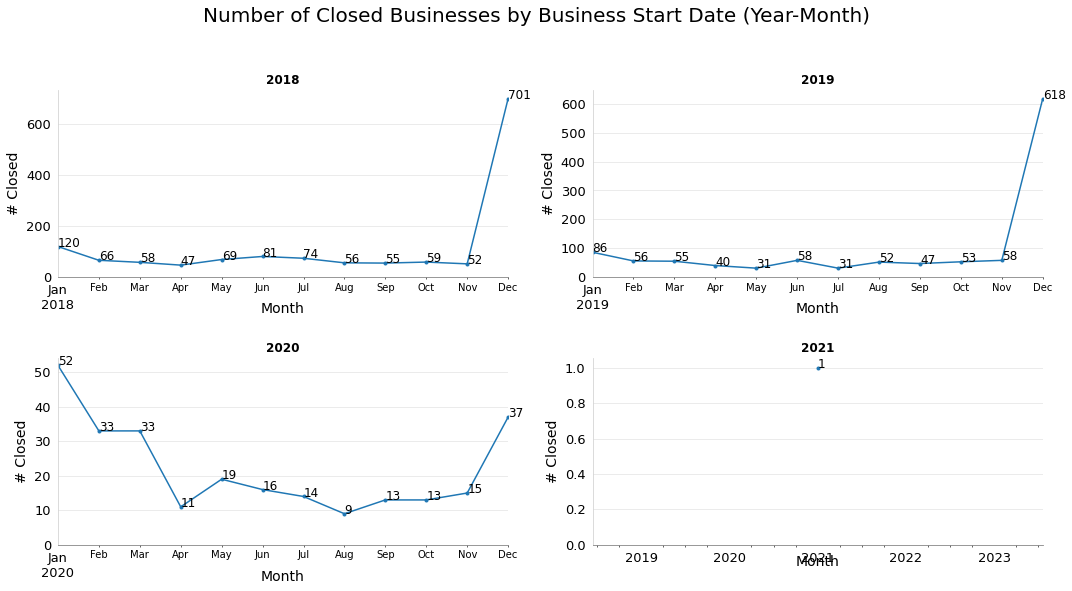

In [155]:
axes = [(row,col) for row in range(2) for col in range(2)]
fig, ax = plt.subplots(figsize=(15,8),nrows=2,ncols=2)

for year,i in zip(np.sort(results_df['Eyear'].dropna().unique()),axes):
    # monthly number of closed businesses
    DF = results_df[results_df['Eyear']==year].resample('M',on='location_end_date').size()
    DF.plot(ax=ax[i],style='.-')
    ax[i].set_ylim(bottom=0) 
    
    modifyChartBasic(ax[i],13,grid='y') # grid and label size
    lineFigText(ax[i],fontsize=12) #text annotation
    
    ax[i].set_title('\n'+str(int(year)),fontweight="bold")
    ax[i].set_ylabel("# Closed",fontsize=14)
    ax[i].set_xlabel("Month",fontsize=14,labelpad=-10)
    
plt.suptitle('Number of Closed Businesses by Business Start Date (Year-Month)',fontsize=20,y=1.02)
fig.subplots_adjust(bottom=.5,wspace=.5)
plt.tight_layout()

Share of Closed Businesses by Zip Code

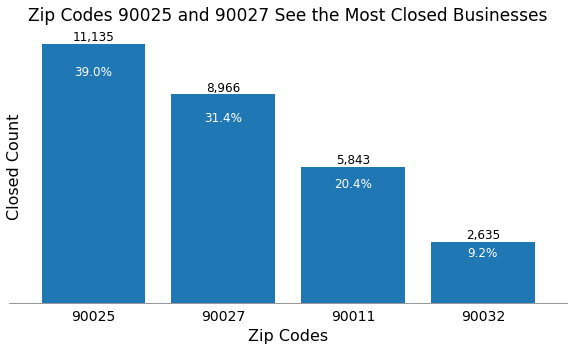

In [156]:
# absolute values
ax=results_df['zip_code'].value_counts().plot.bar(rot=0,figsize=(10,5),width=.8)
# relative values
val =results_df['zip_code'].value_counts(normalize=True).multiply(100).values

modifyChartBasic(ax,14)
ax.set_yticklabels([]) # no y-tick labels
ax.spines['left'].set_visible(False) # no left spine

for bar,rel in zip(ax.patches,val):
    height = bar.get_height()
    position = bar.get_x()
    centerOfBarWidth = bar.get_width()/2 
    # text for relative values
    ax.text(position+centerOfBarWidth, height-height/12,f"{rel:.1f}%",
            fontsize=12,ha='center',va='top',color='white')
    # text for absolute values
    ax.text(position+centerOfBarWidth, height,f"{height:,.0f}",
            fontsize=12,ha='center',va='bottom')
    
plt.title('Zip Codes 90025 and 90027 See the Most Closed Businesses',fontsize=17,pad=10)
plt.xlabel('Zip Codes')
plt.ylabel('Closed Count',labelpad=-20)
plt.show()

### Closed/Open Normalized Value Counts Per Zip Code

<AxesSubplot:ylabel='zip_code'>

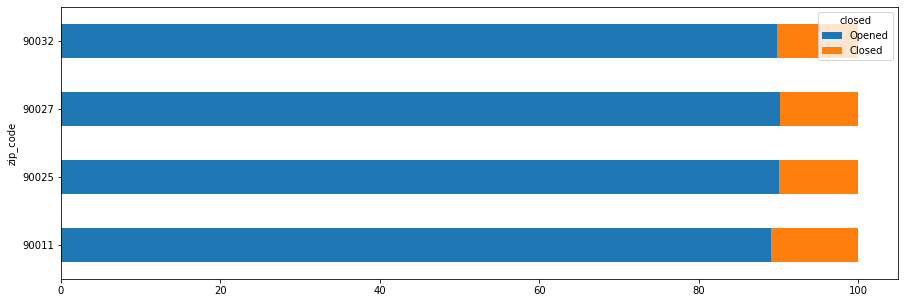

In [157]:
(results_df.groupby('zip_code') # per zip code
 .apply(lambda x: 
        x['closed'] # for closed column
        .value_counts(normalize=True) # get normalized values
        .multiply(100).round(2)) # and format it as a percentage
 .rename(columns={1: 'Closed', 0: 'Opened'})
 .plot
 .barh(stacked=True,figsize=(15,5))
)

### Absolute Values For years 2018 to 2020 Per Zip Code

In [158]:
(results_df
    .query('Eyear in [2018,2019, 2020]') # keep only 2019 and 2020
    .groupby('zip_code') # per zip code 
    .apply(lambda x: x['Eyear'].value_counts()) # value counts per year
    .unstack(1)).to_frame() # unstack columns at index 1 (index 1 = Eyear column)

0
Eyear  zip_code     
2018.0 90011     321
       90025     559
       90027     421
       90032     137
2019.0 90011     258
       90025     451
       90027     367
       90032     109
2020.0 90011      62
       90025      91
       90027      89
       90032      23

As seen in the closed business chart, the number of closed business has been decreasing over the years across the zip codes studied. This result was a countrintuitive finding as we expected COVID-19 business closures to have resulted in higher number of closed businesses. This points to some potential data quality issues with this dataset. 

The best bet is to contact the dataset owner to see if we can get further insights regarding the low number of closed businesses.